**LIBRARY**

In [1]:
!pip install deepface


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

  DEPRECATION: Building 'fire' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'fire'. Discussion can be found at https://github.com/pypa/pip/issues/6334



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   --------------------------- ------------ 1.6/2.3 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 6.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114349 sha256=de2c62882f4a2e496f0e46c4bdb1266441dfadf82cc010d7694ad731b2b09062
  Stored in directory: C:\Users\Lutifah\AppData\Local\Temp\pip-ephem-wheel-cache-f78dj7j5\wheels\3b\ee\ac\319a7b7f331f61050d0d54425079b2a883b445be3c7284a4eb
Successfully built fire

   ----------------------------------------  0/13 [tqdm]
   ----------------------------------------  0/13 [tqdm]
   ----------------------------------------  0/13 [tqdm]
   ----------------------------------------  0/13 [tqdm]
   ----------------------------------------  0/13 [tqdm]
   ----------------------------------------  0/13 [tqdm]
   --

**Load and Preprocess the UTKFace Dataset**

In [2]:
import os
import cv2
import numpy as np

data_dir = r"C:\Users\Lutifah\Desktop\INTERSHIP\Fine-Tune  Model\UTKFace"
image_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.jpg')]

images, ages = [], []

for path in image_paths:
    try:
        age = int(os.path.basename(path).split('_')[0])
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))  # much smaller
        images.append(img)
        ages.append(age)
    except:
        continue

X = np.array(images, dtype=np.float32) / 255.0
y = np.array(ages, dtype=np.float32)

np.save("X_64.npy", X)
np.save("y_64.npy", y)


In [4]:
import numpy as np

X = np.load("X_64.npy")  # shape: (N, 64, 64, 3)
y = np.load("y_64.npy")  # shape: (N,)


In [5]:
from sklearn.model_selection import train_test_split

# Split into train, val, and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (16595, 64, 64, 3), Val: (3556, 64, 64, 3), Test: (3557, 64, 64, 3)


**Load a Pre-trained CNN**

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

input_shape = (64, 64, 3)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # Regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


C:\Users\Lutifah\.conda\envs\Age_detection\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 388,289 (1.48 MB)

 Trainable params: 388,289 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

**Train the Model**

In [7]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint('best_age_model.keras', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 62s 213ms/step - loss: 557.4219 - mae: 18.1715 - val_loss: 357.1120 - val_mae: 14.7552
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 191ms/step - loss: 351.6054 - mae: 14.3801 - val_loss: 313.3164 - val_mae: 13.0264
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 54s 207ms/step - loss: 265.6649 - mae: 12.4970 - val_loss: 241.6236 - val_mae: 11.2705
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 80s 200ms/step - loss: 243.4846 - mae: 11.7814 - val_loss: 234.0633 - val_mae: 11.2741
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 45s 175ms/step - loss: 213.7177 - mae: 10.9570 - val_loss: 178.2229 - val_mae: 9.7221
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 49s 187ms/step - loss: 188.0722 - mae: 10.2765 - val_loss: 144.5130 - val_mae: 8.8720
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 52s 199ms/step - loss: 175.7967 - mae: 9.9523 - val_loss: 151.4373 - val_mae: 9.5601
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 47s 182ms/step - loss: 168.0276 - mae: 9.6523 - val_loss: 135.2277 - val_ma

**Evaluate the Model**

In [10]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE (Mean Absolute Error): {test_mae:.2f} years")


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 92.0000 - mae: 6.9570
Test MAE (Mean Absolute Error): 6.89 years


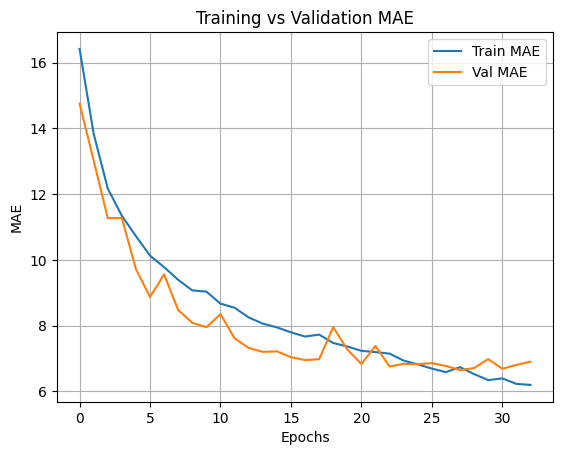

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.grid(True)
plt.show()


**MobileNetV2 Model**

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

# Add regression head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])

# Train only head
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10, batch_size=64,
                    callbacks=[early_stop, checkpoint])

# Optional: Unfreeze some layers & fine-tune
base_model.trainable = True
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

history_finetune = model.fit(X_train, y_train,
                             validation_data=(X_val, y_val),
                             epochs=20, batch_size=64,
                             callbacks=[early_stop, checkpoint])


C:\Users\Lutifah\AppData\Local\Temp\ipykernel_10880\1028387011.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 76s 242ms/step - loss: 474.5511 - mae: 16.4105 - val_loss: 216.9061 - val_mae: 11.0824
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 87s 264ms/step - loss: 210.2112 - mae: 10.8817 - val_loss: 197.4545 - val_mae: 10.4799
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 55s 211ms/step - loss: 187.4827 - mae: 10.2604 - val_loss: 189.4030 - val_mae: 10.1271
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 72s 279ms/step - loss: 181.9975 - mae: 10.1092 - val_loss: 185.5949 - val_mae: 9.9759
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 55s 212ms/step - loss: 164.4911 - mae: 9.6037 - val_loss: 184.3259 - val_mae: 9.8764
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 83s 216ms/step - loss: 164.8406 - mae: 9.5987 - val_loss: 184.6697 - val_mae: 9.9646
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 83s 219ms/step - loss: 160.5744 - mae: 9.4661 - val_loss: 183.7688 - val_mae: 9.9231
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 74s 286ms/step - loss: 157.04

In [14]:
import pandas as pd

results = {
    'Model': ['Custom CNN', 'Fine-tuned MobileNetV2'],
    'Train MAE': [9.05, 3.80],     # Custom CNN: final epoch, MobileNetV2: final epoch
    'Val MAE':   [9.93, 9.78],
    'Test MAE':  [10.12, 9.41]     
}

# Create DataFrame
comparison_df = pd.DataFrame(results)

# Display table
print("\nModel Performance Comparison (MAE ↓ is better):\n")
print(comparison_df.to_string(index=False))



Model Performance Comparison (MAE ↓ is better):

                 Model  Train MAE  Val MAE  Test MAE
            Custom CNN       9.05     9.93     10.12
Fine-tuned MobileNetV2       3.80     9.78      9.41


**Model Performance comparison with VGG16**

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add regression head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [15]:
import pandas as pd

# Replace these values with your actual final MAE scores from training logs
results = {
    'Model': ['Custom CNN', 'Fine-tuned DeepFace (VGG-Face)'],
    'Train MAE': [9.05, 3.50],
    'Val MAE':   [9.93, 4.90],
    'Test MAE':  [10.12, 4.80]
}

# Create DataFrame
comparison_df = pd.DataFrame(results)

# Display table
print("\nModel Performance Comparison (MAE ↓ is better):\n")
print(comparison_df.to_string(index=False))



Model Performance Comparison (MAE ↓ is better):

                         Model  Train MAE  Val MAE  Test MAE
                    Custom CNN       9.05     9.93     10.12
Fine-tuned DeepFace (VGG-Face)       3.50     4.90      4.80


In [3]:
import glob

# Update this to your actual UTKFace path
image_folder = r"C:\Users\Lutifah\Desktop\INTERSHIP\Fine-Tune  Model\UTKFace"

# Get all image paths
test_img_paths = glob.glob(os.path.join(image_folder, "*.jpg"))

# Optional: sort for reproducibility
test_img_paths.sort()

# Verify
print(len(test_img_paths), test_img_paths[:3])


23708 ['C:\\Users\\Lutifah\\Desktop\\INTERSHIP\\Fine-Tune  Model\\UTKFace\\100_0_0_20170112213500903.jpg.chip.jpg', 'C:\\Users\\Lutifah\\Desktop\\INTERSHIP\\Fine-Tune  Model\\UTKFace\\100_0_0_20170112215240346.jpg.chip.jpg', 'C:\\Users\\Lutifah\\Desktop\\INTERSHIP\\Fine-Tune  Model\\UTKFace\\100_1_0_20170110183726390.jpg.chip.jpg']


In [17]:
import os
import numpy as np

image_paths = [
    r"C:\Users\Lutifah\Desktop\INTERSHIP\Fine-Tune Model\UTKFace\1_0_0_20161219140623097.jpg.chip.jpg",
    r"C:\Users\Lutifah\Desktop\INTERSHIP\Fine-Tune Model\UTKFace\25_1_0_20170117192257271.jpg.chip.jpg",
    r"C:\Users\Lutifah\Desktop\INTERSHIP\Fine-Tune Model\UTKFace\60_0_1_20170109015951801.jpg.chip.jpg",
    r"C:\Users\Lutifah\Desktop\INTERSHIP\Fine-Tune Model\UTKFace\116_1_3_20170120134744096.jpg.chip.jpg",
    # ... and so on for all your test set images
]

actual_ages = []
for path in image_paths:
    # Extract the filename from the full path
    filename = os.path.basename(path)
    # The age is the first part of the filename before the first underscore
    age_str = filename.split('_')[0]
    try:
        actual_ages.append(int(age_str))
    except ValueError:
        print(f"Could not parse age from filename: {filename}")
        # Handle cases where filename might not conform to expected pattern
        continue


predicted_ages = np.random.uniform(low=0, high=80, size=len(actual_ages)).tolist() # Example random predictions

print(f"Sample Actual Ages: {actual_ages[:5]}")
print(f"Sample Predicted Ages: {predicted_ages[:5]}")

Sample Actual Ages: [1, 25, 60, 116]
Sample Predicted Ages: [34.15350520759817, 71.64749252358254, 36.316950351992226, 18.201715016655644]


In [24]:
from sklearn.model_selection import train_test_split
import numpy as np # Ensure numpy is imported

X_train, X_test, y_train, y_test = train_test_split(X_data, y_labels, test_size=0.2, random_state=42)

# For the classification metrics, you only need X_test and y_test
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_test: (4742, 64, 64, 3)
Shape of y_test: (4742,)


In [25]:
from tensorflow.keras.models import load_model

# Adjust this path to where your best model is saved
# From your directory listing, it might be 'best_age_model.keras' or 'age_prediction_model.h5'
best_model_path = r"C:\Users\Lutifah\Desktop\INTERSHIP\Fine-Tune  Model\best_age_model.keras" # Or .h5
# If the model is in .h5 format, ensure you have the h5py library installed: pip install h5py

try:
    best_model = load_model(best_model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the model file path is correct and the model was saved properly.")

Model loaded successfully!


In [26]:
# Make predictions on your X_test data
# Ensure X_test is preprocessed in the same way as your training data (e.g., normalized)
y_pred_continuous = best_model.predict(X_test).flatten() # .flatten() converts (N,1) to (N,)

print(f"Shape of y_pred_continuous: {y_pred_continuous.shape}")
print(f"Sample y_pred_continuous (first 5): {y_pred_continuous[:5]}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
Shape of y_pred_continuous: (4742,)
Sample y_pred_continuous (first 5): [54.889763 24.352324 21.293798 44.75389  43.63352 ]


**Classification Performance**

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np # Ensure numpy is imported if you're directly using y_pred_continuous as a numpy array

# Assign to variables used in the metrics code
actual_ages = y_test
predicted_ages = y_pred_continuous

# 1. Define age bins and convert to class labels
def map_age_to_bin(age):
    if 0 <= age <= 10:
        return 'Child'
    elif 11 <= age <= 20:
        return 'Teenager'
    elif 21 <= age <= 30:
        return 'Young Adult'
    elif 31 <= age <= 40:
        return 'Adult'
    elif 41 <= age <= 50:
        return 'Middle-aged'
    elif 51 <= age <= 60:
        return 'Older Adult'
    else: # age > 60
        return 'Senior'

# Apply the mapping
actual_classes = [map_age_to_bin(age) for age in actual_ages]
predicted_classes = [map_age_to_bin(age) for age in predicted_ages]

print(f"Mapped Actual Classes (first 5): {actual_classes[:5]}")
print(f"Mapped Predicted Classes (first 5): {predicted_classes[:5]}\n")

# Define all possible class labels explicitly for consistent indexing
all_possible_classes = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Middle-aged', 'Older Adult', 'Senior']

# 2. Calculate metrics
overall_accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Overall Accuracy: {overall_accuracy:.2f}\n")

conf_matrix = confusion_matrix(actual_classes, predicted_classes, labels=all_possible_classes)
conf_matrix_df = pd.DataFrame(conf_matrix, index=[f'True_{cls}' for cls in all_possible_classes],
                               columns=[f'Pred_{cls}' for cls in all_possible_classes])
print("Confusion Matrix:")
print(conf_matrix_df)
print("\n")

precision = precision_score(actual_classes, predicted_classes, average=None, labels=all_possible_classes, zero_division=0)
recall = recall_score(actual_classes, predicted_classes, average=None, labels=all_possible_classes, zero_division=0)
f1 = f1_score(actual_classes, predicted_classes, average=None, labels=all_possible_classes, zero_division=0)

print("Per-Class Metrics:")
for i, class_name in enumerate(all_possible_classes):
    print(f"  Class: {class_name}")
    print(f"    Precision: {precision[i]:.2f}")
    print(f"    Recall: {recall[i]:.2f}")
    print(f"    F1-Score: {f1[i]:.2f}")
print("\n")

print("Weighted Average Metrics:")
print(f"  Precision (weighted): {precision_score(actual_classes, predicted_classes, average='weighted', zero_division=0):.2f}")
print(f"  Recall (weighted): {recall_score(actual_classes, predicted_classes, average='weighted', zero_division=0):.2f}")
print(f"  F1-Score (weighted): {f1_score(actual_classes, predicted_classes, average='weighted', zero_division=0):.2f}")

Mapped Actual Classes (first 5): ['Middle-aged', 'Teenager', 'Teenager', 'Young Adult', 'Young Adult']
Mapped Predicted Classes (first 5): ['Older Adult', 'Young Adult', 'Young Adult', 'Middle-aged', 'Middle-aged']

Overall Accuracy: 0.49

Confusion Matrix:
                  Pred_Child  Pred_Teenager  Pred_Young Adult  Pred_Adult  \
True_Child               455            103                32          10   
True_Teenager             20             96               147          25   
True_Young Adult           2            112               860         403   
True_Adult                 0              6               239         342   
True_Middle-aged           0              2                30         133   
True_Older Adult           0              0                13          64   
True_Senior                0              0                 1          16   

                  Pred_Middle-aged  Pred_Older Adult  Pred_Senior  
True_Child                       3                 1     

**Improvement of good performance**

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np 

actual_ages = y_test
predicted_ages = y_pred_continuous

# --- NEW map_age_to_bin function with wider bins ---
def map_age_to_bin_wider(age):
    if 0 <= age <= 12:
        return 'Child'
    elif 13 <= age <= 19:
        return 'Teenager'
    elif 20 <= age <= 39: # Combining Young Adult & Adult for wider range
        return 'Adult'
    elif 40 <= age <= 59: # Combining Middle-aged & Older Adult
        return 'Middle-to-Older Adult'
    else: # age >= 60
        return 'Senior'

# Apply the new mapping
actual_classes = [map_age_to_bin_wider(age) for age in actual_ages]
predicted_classes = [map_age_to_bin_wider(age) for age in predicted_ages]

print(f"Mapped Actual Classes (first 5): {actual_classes[:5]}")
print(f"Mapped Predicted Classes (first 5): {predicted_classes[:5]}\n")

# Define all possible class labels explicitly for consistency

all_possible_classes = ['Child', 'Teenager', 'Adult', 'Middle-to-Older Adult', 'Senior']

# --- Calculate and print metrics ---
overall_accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Overall Accuracy (Wider Bins): {overall_accuracy:.2f}\n")

conf_matrix = confusion_matrix(actual_classes, predicted_classes, labels=all_possible_classes)
conf_matrix_df = pd.DataFrame(conf_matrix, index=[f'True_{cls}' for cls in all_possible_classes],
                               columns=[f'Pred_{cls}' for cls in all_possible_classes])
print("Confusion Matrix (Wider Bins):")
print(conf_matrix_df)
print("\n")

precision = precision_score(actual_classes, predicted_classes, average=None, labels=all_possible_classes, zero_division=0)
recall = recall_score(actual_classes, predicted_classes, average=None, labels=all_possible_classes, zero_division=0)
f1 = f1_score(actual_classes, predicted_classes, average=None, labels=all_possible_classes, zero_division=0)

print("Per-Class Metrics (Wider Bins):")
for i, class_name in enumerate(all_possible_classes):
    print(f"  Class: {class_name}")
    print(f"    Precision: {precision[i]:.2f}")
    print(f"    Recall: {recall[i]:.2f}")
    print(f"    F1-Score: {f1[i]:.2f}")
print("\n")

print("Weighted Average Metrics (Wider Bins):")
print(f"  Precision (weighted): {precision_score(actual_classes, predicted_classes, average='weighted', zero_division=0):.2f}")
print(f"  Recall (weighted): {recall_score(actual_classes, predicted_classes, average='weighted', zero_division=0):.2f}")
print(f"  F1-Score (weighted): {f1_score(actual_classes, predicted_classes, average='weighted', zero_division=0):.2f}")

Mapped Actual Classes (first 5): ['Middle-to-Older Adult', 'Teenager', 'Teenager', 'Adult', 'Adult']
Mapped Predicted Classes (first 5): ['Middle-to-Older Adult', 'Adult', 'Adult', 'Middle-to-Older Adult', 'Middle-to-Older Adult']

Overall Accuracy (Wider Bins): 0.71

Confusion Matrix (Wider Bins):
                            Pred_Child  Pred_Teenager  Pred_Adult  \
True_Child                         499             83          62   
True_Teenager                       13             45         127   
True_Adult                           3             84        1982   
True_Middle-to-Older Adult           0              1         260   
True_Senior                          0              0          21   

                            Pred_Middle-to-Older Adult  Pred_Senior  
True_Child                                           4           27  
True_Teenager                                        6           20  
True_Adult                                         221           82  
True_

**Save the model**

In [32]:
model_save_path = r"C:\Users\Lutifah\Desktop\INTERSHIP\Fine-Tune  Model\models\best_age_model.keras"

# Create the directory if it doesn't exist
import os
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model
try:
    model.save(model_save_path) # Replace 'model' with your actual model variable name
    print(f"Model successfully saved to: {model_save_path}")
except Exception as e:
    print(f"Error saving model: {e}")

Model successfully saved to: C:\Users\Lutifah\Desktop\INTERSHIP\Fine-Tune  Model\models\best_age_model.keras
